**1. Считайте wav-файл.<br>Выведите частоту дискретизации.<br>Отобразите две секунды данных на графике.**<br>

Частота дискретизации = 11025
29625 -29676


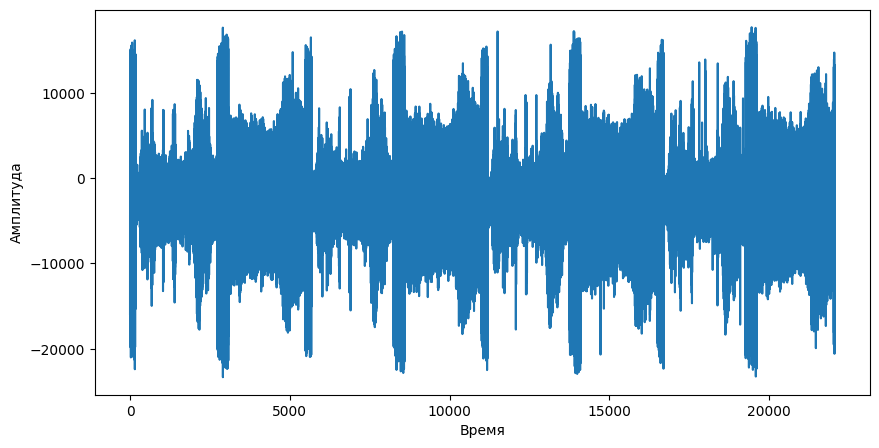

In [1]:
from scipy import signal
from matplotlib import pyplot as plt
import numpy as np
from scipy.io import wavfile

test_start, test_finish = 300, 302

sample_rate, data = wavfile.read('lw2.wav')
print('Частота дискретизации =', sample_rate)
print(np.max(data), np.min(data))
plt.figure(figsize=(10,5))
plt.plot(data[test_start*sample_rate:test_finish*sample_rate])
plt.ylabel("Амплитуда")
plt.xlabel("Время")  


plt.show()

**2. Осуществите преобразование Гильберта.<br>Постройте огибающую амплитуды аналитического сигнала.<br>Добавьте на график из п. 1 получившуюся огибающую амплитуды.**

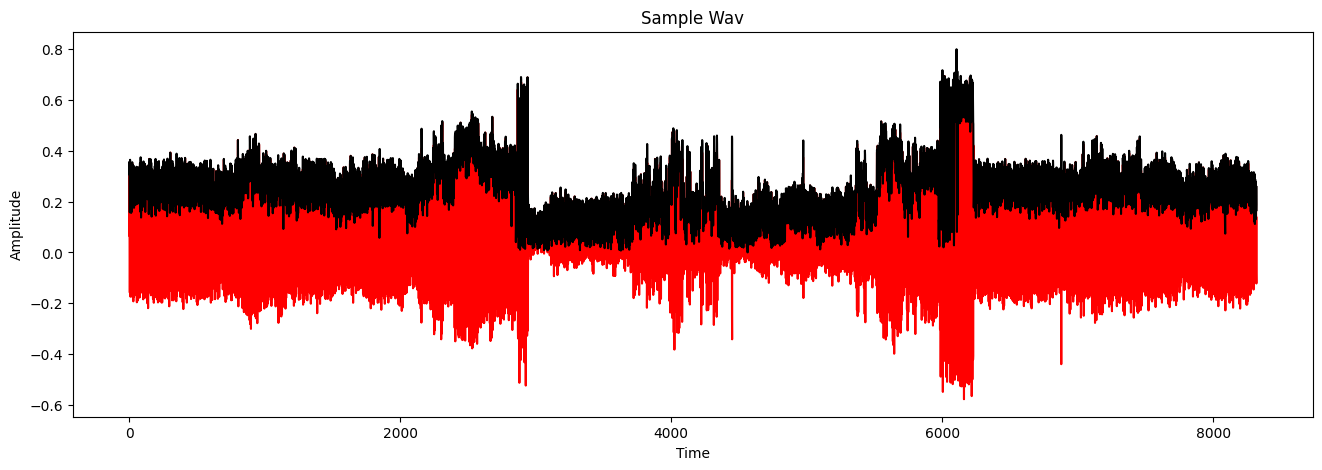

In [2]:
from scipy.signal import hilbert

new_sample_rate = 2*2080
k = 3
data = np.array(data, dtype=np.float64)
data = signal.resample(data,int(len(data)/sample_rate*new_sample_rate*k))

data = (data - data.mean())/(data - data.mean()).max()
analytic_signal = hilbert(data)
amplitude_envelope = np.abs(analytic_signal)

plt.figure(figsize=(16,5))
plt.plot(data[test_start*new_sample_rate:test_finish*new_sample_rate], color = "red")
plt.plot(amplitude_envelope[test_start*new_sample_rate:test_finish*new_sample_rate], color = "black")

plt.ylabel("Amplitude")
plt.xlabel("Time")  
plt.title("Sample Wav")
plt.show()

**3. Постройте и отобразите изображение из полученных данных.**

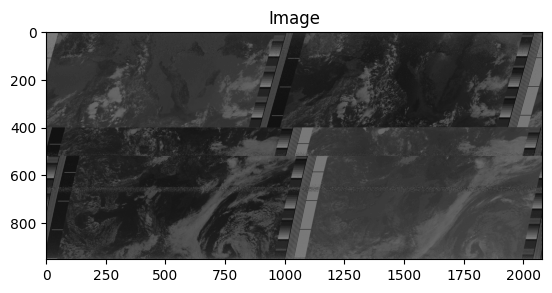

In [3]:
str_len = int(sample_rate / 2)
channel_len = int(str_len / 2)

strings = []
for i in range(0, len(amplitude_envelope), int(new_sample_rate*k/2)):
    string = amplitude_envelope[i:i+int(new_sample_rate*k/2):k]
    strings.append(string)


plt.imshow(strings[:-1], cmap='gray') 
plt.title('Image')
plt.show()

**4. Измените частоту дискретизации в соответствии с форматом APT (можно выполнить на предыдущих шагах).<br>Выровняйте изображение по синхроимпульсу.**

[0. 0. 0. 0. 1. 1. 0. 0. 1. 1. 0. 0. 1. 1. 0. 0. 1. 1. 0. 0. 1. 1. 0. 0.
 1. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


<function matplotlib.pyplot.show(close=None, block=None)>

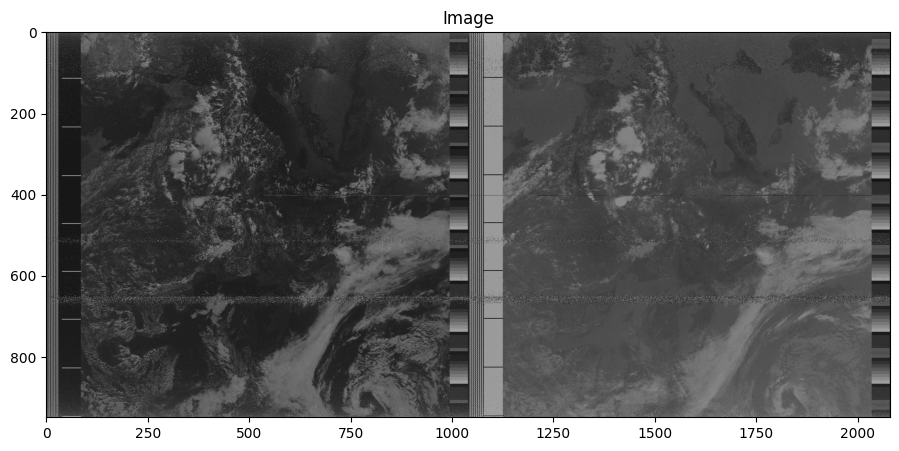

In [4]:
import matplotlib

resampled = np.array(string[:-1], dtype=float)
resampled = resampled.flatten()

s2 = np.array(strings[:-1])
s2.shape
np.amax(s2), np.amin(s2)
strings = np.array(string)
flat_strings = s2.flatten()

sync = np.array([0]*4+[1,1,0,0]*7 + [0]*7, dtype = float)
print(sync)
range_between = 2000
peaks = [(0,0)]
signal_shift = flat_strings - 0.5
sync -= 0.5
img = []

for i in range(len(flat_strings) - len(sync)):
    edge = np.dot(sync, signal_shift[i : i + len(sync)])
    if i - peaks[-1][0] > range_between:
        peaks.append((i, edge))
    elif edge > peaks[-1][1]:
        peaks[-1] = (i, edge)

for i in range(len(peaks) - 1):
    img.append(flat_strings[peaks[i][0]:peaks[i][0] + 2080])

plt.figure(figsize=(16,5))
plt.imshow(img[:-1], cmap='gray')
plt.title('Image')
plt.show

**5. Сделайте самый темный пиксель черным, а самый светлый - белым.**

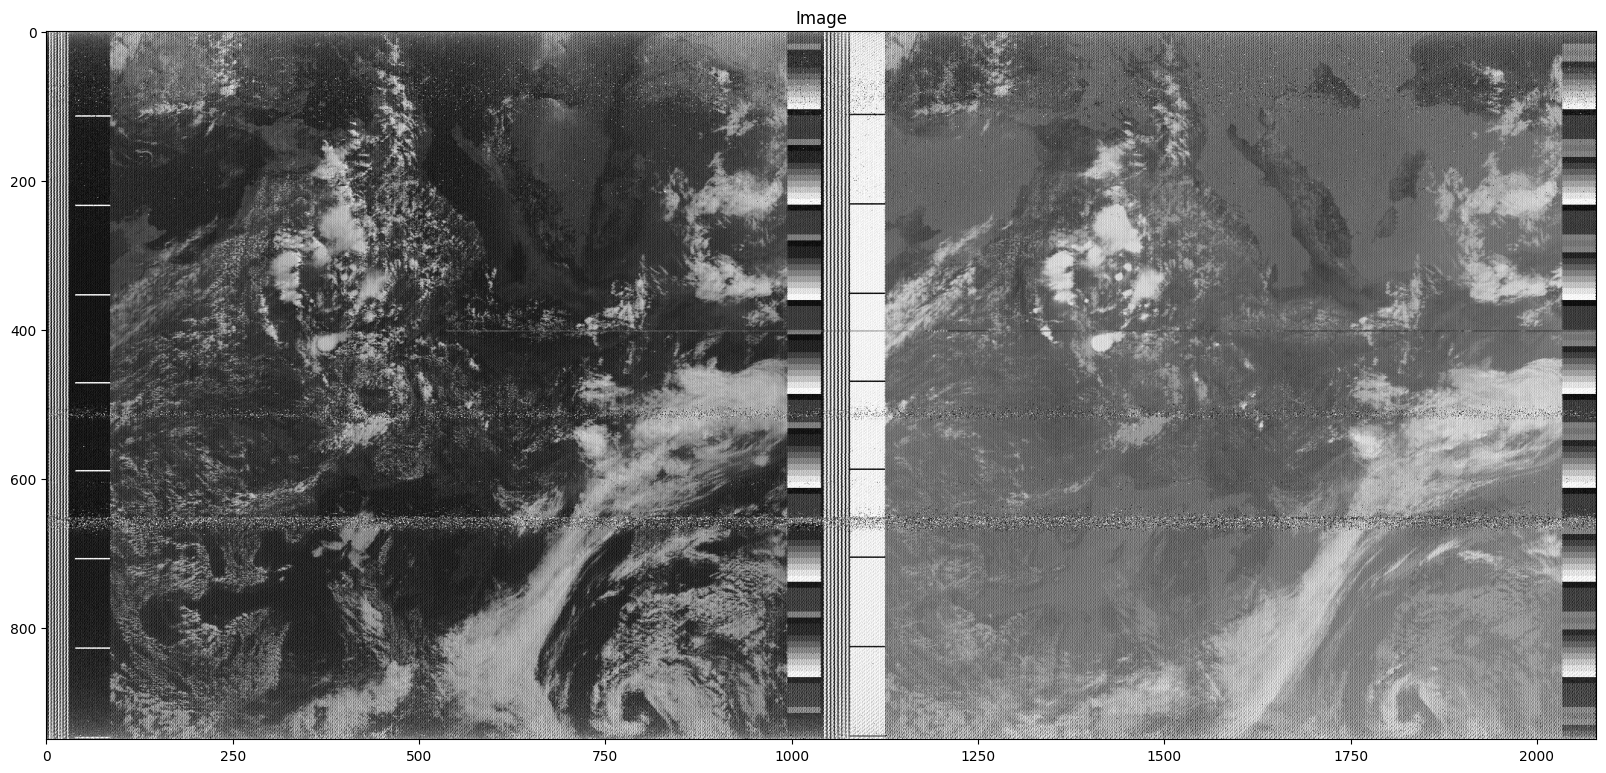

In [ ]:
p2, p98 = np.percentile(img, (2, 98))

a = (255 * (img - p2) / (p98 - p2)).astype(np.float32)
a[a < 0] = 0
a[a > 255] = 255

plt.figure(figsize = (20, 16))
plt.imshow(a, cmap='gray') # np.transpose
plt.title('Image')
plt.show()

img = a

**6. Выделите блоки телеметрии.<br>Выведите получившиеся яркостные температуры платиновых терморезисторов $C_{N}$,
$N \in [1, 4]$, АЧТ $C_{BB}$ и реликтового излучения $C_S$.<br>
Изображение должно быть нормализованным и иметь значения интенсивностей в диапазоне 0-255.**

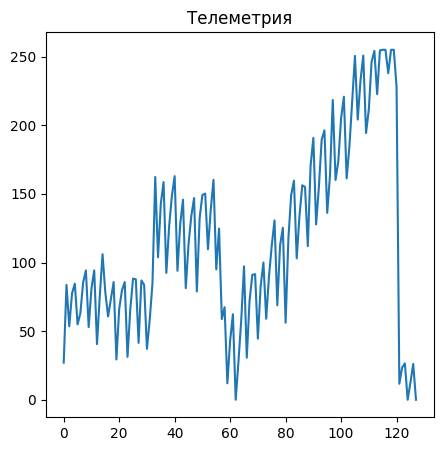

Интенсивности: [63.47766, 77.78606, 68.68583, 70.16076, 124.45415, 122.76192]


In [6]:
a = []
Img = np.array(img)
for i in range(Img.shape[0]):
    a.append(Img[i][Img.shape[1]-17])
    
grid1 = a.index(np.min(a[240]))
grid2 = grid1+128

telemetry = a[grid1:grid2]
plt.figure(figsize=(5,5))
plt.plot(telemetry)
plt.title('Телеметрия')
plt.show()
count = np.linspace(0,128,17)
count = np.array(count[:-1], dtype = np.int32)
temp = []

for i in count:
    temp.append(np.mean(telemetry[i:i+7]))

print("Интенсивности:", temp[0:6])

**7. Вычислите термодинамическую температуру терморезисторов по формуле: $T_N = d_0 + d_1 C_N + d_2 C_N^2$.**

|N|$d_0$|$d_1$|$d_2$|
|:-:|:-:|:-:|:-:|
|1|276.6067|0.051111|1.405783E-6|
|2|276.6119|0.051090|1.496037E-6|
|3|276.6311|0.051033|1.496990E-6|
|4|276.6268|0.051058|1.493110E-6|

**Температура АЧТ $T_{BB}$ - среднее арифметическое значение этих температур.**

**Эффективную температуру, учитывающую размеры АЧТ, вычисите согласно выражению: $T_{BB}^{*} = A + B T_{BB}$.**<br>
**Коэффициенты преобразования $A$ и $B$ указываются производителем спутника: $A = 1.67396$, $B = 0.997364$.**

In [7]:
# Ваш код

**8. Для перевода значения излучения с поверхности Земли в градусы Кельвина, производителем спутника составляется таблица соответствия в диапазоне 180-340К. На основе этой таблицы вычисляются коэффициенты для формулы преобразования из термодинамической температуры в яркостную:**

$$N_{BB}=\frac{c_1 u_{e}^3}{\exp\left(\frac{c_2 u_c}{T_{BB}^*}\right) - 1}$$

**Вычислите $N_{BB}$, используя значения $с_1 = 1.1910E^{-5}$, $c_2 = 1.4388$, $u_e = u_c = 2670$.**

**Яркостная температура из ИК канала вычисляется согласно $N_E = N_{BB}\frac{C_S - C_E}{C_S - C_{BB}}$. <br>$C_E$ - значение яркости пикселя на изображении.**

**9. Вычислите яркостную температуру пикселя с поверхности Земли и обратным преобразованием (формула из п. 8) получите термодинамическую температуру. Далее внесите коррекцию в показатель температуры, с учетом конструкции спутника. Иными словами переведите яркостную температуру в эффективную и из эффективной температуры получите термодинамическую:**

$$T_E^* = \frac{c_2 u_c}{\ln\left[1 + \left(\frac{c_1 u_c^3}{N_E}\right)\right]}$$

$$T_E = \frac{T_E^* - A}{B}$$

**Постройте получившуюся тепловую карту, добавьте [colorbar](https://matplotlib.org/stable/gallery/color/colorbar_basics.html).**

In [8]:
# Ваш код